<a href="https://colab.research.google.com/github/xx529/Reinforcement-Learning/blob/main/Policy%20Gradient/Reducing_Variance_Using_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducing_Variance_Using_Baseline

* $\nabla E_{\tau\sim\pi_{\theta}}[R]=E_{\tau}[\sum_{t=0}^{\tau-1}G_t \nabla_{\theta}log\pi_{\theta}(a_t|s_t)]$

* 其中 $G_t=\sum_{t^{\prime}=t}^{\tau-1}r_{t^{\prime}}$ 就是在 $t^{\prime}$ 时刻的总 reward 

# Agent

In [1]:
import torch.nn as nn
import torch

class Agent(nn.Module):
    def __init__(self, ):
        super(Agent, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.6)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.save_log_prob = []
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        policy = self.softmax(x)
        return policy

# Emulator

In [2]:
import gym
from torch.distributions import Categorical
import numpy as np

class Emulator:
    def __init__(self, name, gamma=0.9, max_iter=10000):
        self.env = gym.make(name)
        self.gamma = gamma
        self.current_state = None
        self.max_iter = max_iter

    def do(self, agent):
        self.current_state = self.env.reset()
        self.reward_seq = []
        
        done = False
        current_iter = 0
        while not done and current_iter < self.max_iter:
            done = self.step(agent)
            current_iter += 1

    def step(self, agent):
        action_probs = agent(torch.from_numpy(self.current_state).float().unsqueeze(0))
        m = Categorical(action_probs)
        action = m.sample()
        agent.save_log_prob.append(m.log_prob(action))
        
        self.current_state, reward, done, _ = self.env.step(action.item())
        self.reward_seq.append(reward)

        return done

    def get_Gt(self):
        Gt_array = np.zeros_like(self.reward_seq)

        current_Gt = 0
        for idx, r in enumerate(self.reward_seq[::-1]):
            current_Gt = r + self.gamma * current_Gt
            Gt_array[-(idx+1)] = current_Gt

        Gt_array = Gt_array - Gt_array.mean()
        
        return Gt_array


# Training

In [3]:
from torch import optim
import matplotlib.pyplot as plt


agent = Agent()
emulator = Emulator('CartPole-v1')
optimizer = optim.Adam(agent.parameters(), lr=1e-2)
reward_list = []

stop_threshold = emulator.env.spec.reward_threshold
current_threshold = 0

e = 0
# while current_threshold < stop_threshold:
while e < 10000:
    agent_loss = []

    emulator.do(agent)
    Gt = emulator.get_Gt()

    for log_prob, gt in zip(agent.save_log_prob, Gt):
        agent_loss.append(-log_prob * gt)

    agent_loss = torch.cat(agent_loss).sum()
    
    optimizer.zero_grad()
    agent_loss.backward()
    optimizer.step()

    agent.save_log_prob = []
    
    total_reward = sum(emulator.reward_seq)
    reward_list.append(total_reward)
    current_threshold = 0.5 * current_threshold + 0.5 * total_reward

    e += 1

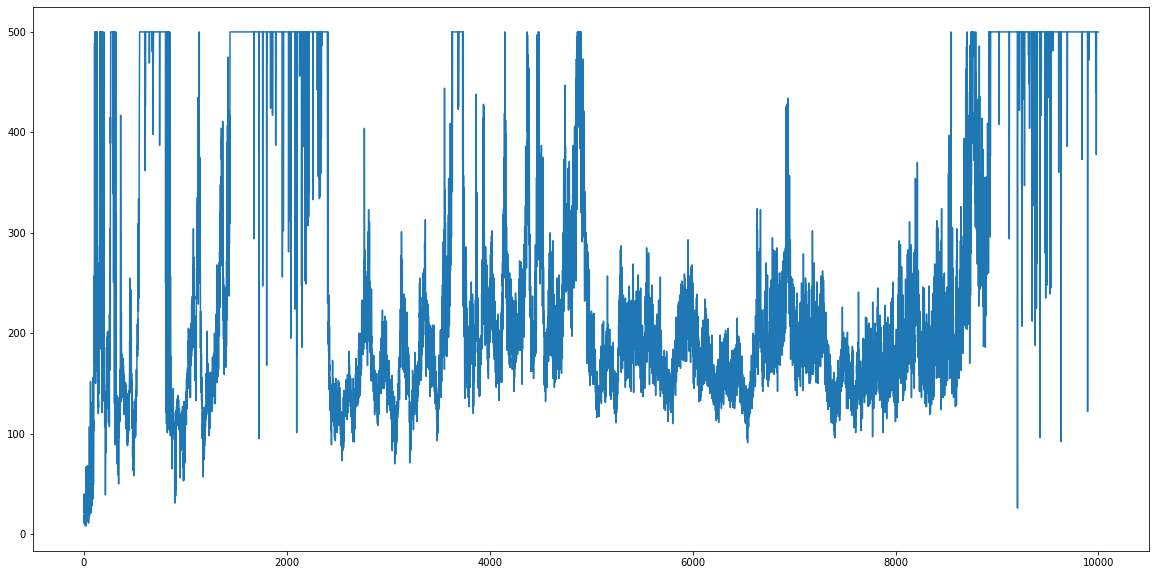

In [4]:
plt.figure(figsize=(20, 10))
plt.plot(reward_list)
plt.show()

In [5]:
# plt.figure(figsize=(20, 10))
# plt.plot(reward_list)
# plt.show()